In [ ]:
!pip -q install torchmetrics gdown

import os, shutil
from collections import Counter, OrderedDict

from google.colab import drive
import kagglehub

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import cv2

import PIL

from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.3 MB/s eta 0:00:00


In [ ]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='cuda')

In [ ]:
# !gdown --id #####ID_HERE##### --output diatom-dataset.zip
# !unzip -q diatom-dataset.zip -d /content/diatom-dataset

diatom_dataset_root_dir = kagglehub.dataset_download("huseyingunduz/diatom-dataset")

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classes = {
  1: "Gomphonema olivaceum",
  2: "Navicula cryptotenella",
  3: "Fragilaria recapitellata",
  4: "Encyonema silesiacum",
  5: "Navicula reichardtiana",
  6: "Planothidium lanceolatum",
  7: "Gomphonema tergestinum",
  8: "Navicula cryptotenelloides",
  9: "Rhoicosphenia abbreviata",
  10: "Meridion circulare",
  11: "Surirella brebissonii var. kuetzingii",
  12: "Encyonema ventricosum",
  13: "Achnanthidium biasolettianum",
  14: "Cymbella excisa",
  15: "Diatoma moniliformis",
  16: "Cymbella cantonatii",
  17: "Diatoma mesodon",
  18: "Humidophila contenta",
  19: "Cocconeis pseudolineata",
  20: "Navicula upsaliensis",
  21: "Cymbella excisa var. subcapitata",
  22: "Halamphora veneta",
  23: "Gomphonema calcifugum",
  24: "Nitzschia linearis",
  25: "Pinnularia brebissonii",
  26: "Humidophila perpusilla",
  27: "Navicula trivialis",
  28: "Gomphonema pumilum var. rigidum",
  29: "Halamphora paraveneta",
  30: "Nitzschia hantzschiana",
  31: "Pantocsekiella ocellata",
  32: "Planothidium frequentissimum",
  33: "Adlafia minuscula",
  34: "Navicula cryptocephala",
  35: "Amphora pediculus",
  36: "Navicula tripunctata",
  37: "Navicula gregaria",
  38: "Nitzschia archibaldii",
  39: "Navicula moskalii",
  40: "Epithemia argus",
  41: "Gomphonema micropus",
  42: "Gomphonema minutum",
  43: "Navicula capitatoradiata",
  44: "Gomphonema drutelingense",
  45: "Denticula kuetzingii",
  46: "Gomphonema supertergestinum",
  47: "Achnanthidium minutissimum",
  48: "Frustulia vulgaris",
  49: "Gomphonema pumilum",
  50: "Hantzschiana abundans",
  51: "Caloneis lancettula",
  52: "Navicula novaesiberica",
  53: "Sellaphora radiosa",
  54: "Navicula lanceolata",
  55: "Gomphonema exilissimum",
  56: "Diploneis fontanella",
  57: "Luticola nivalis",
  58: "Epithemia goeppertiana",
  59: "Nitzschia recta",
  60: "Stauroneis blazenciciae",
  61: "Cymbopleura amphicephala",
  62: "Cymbella excisa var. procera",
  63: "Nitzschia palea",
  64: "Didymosphenia geminata",
  65: "Sellaphora saugerresii",
  66: "Amphora inariensis",
  67: "Neidiomorpha binodiformis",
  68: "Surella minuta"
}

class_to_idx = {v: k for k, v in classes.items()}

In [ ]:
banned_xml_files = [
  "388.xml",
  "1147.xml",
  "366.xml",
  "1418.xml",
  "488.xml",
  "1256.xml",
  "475.xml",
  "1067.xml",
  "1310.xml",
  "453.xml",
  "284.xml",
  "233.xml",
  "437.xml",
]

In [ ]:
def parse_xml(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  objs = []

  for obj in root.findall("objects/object"):
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "objects": objs
  }

parse_xml(os.path.join(diatom_xmls_dir, "25.xml"))

{'filename': '25.png',
 'objects': [{'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [ ]:
class DiatomDataset(Dataset):
  def __init__(self, root_dir, classes, class_to_idx, banned_xml_files=[], transform=None, train=True):
    self.root_dir = root_dir
    self.classes = classes
    self.class_to_idx = class_to_idx
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xml_files = [
      xml_file for xml_file in self.xml_files if xml_file.endswith(".xml") and xml_file not in banned_xml_files
    ]

    split_idx = int(len(self.xml_files) * 0.8)

    if train:
      self.xml_files = self.xml_files[:split_idx]
    else:
      self.xml_files = self.xml_files[split_idx:]

  def __len__(self):
    return len(self.xml_files)

  def __getitem__(self, index):
    xml = parse_xml(os.path.join(self.xml_dir, self.xml_files[index]))

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)

    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]] - 1 # for RetinaNet convention
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
    }

    return image, target

  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

In [ ]:
def to_device(images, targets):
  return [image.to(device) for image in images], [{k: v.to(device) for k, v in target.items()} for target in targets]

In [ ]:
def train_epoch(dataloader, model, optimizer):
  total_loss = 0

  model.train()

  for images, targets in tqdm(dataloader, desc="Training"):
    images, targets = to_device(images, targets)

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    total_loss += losses.item()

  return total_loss / len(dataloader)

def validate_epoch(dataloader, model):
  mean_ap = MeanAveragePrecision().to(device)

  model.eval()

  with torch.no_grad():
    for images, targets in tqdm(dataloader, desc="Validating"):
      images, targets = to_device(images, targets)

      outputs = model(images)

      mean_ap.update(outputs, targets)

  score = mean_ap.compute()
  score_cpu = {k: v.cpu() if torch.is_tensor(v) else v for k, v in score.items()}

  return score

In [ ]:
def plot_detection_train_log(train_losses, val_maps, val_map_50s, val_map_75s):
  epochs = np.arange(1, len(train_losses) + 1)

  plt.figure(figsize=(15, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="Train Loss", marker='o', linewidth=2)
  plt.title("Training Loss over Epochs", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Loss", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(fontsize=10)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, val_maps, label="mAP@[.5:.95]", marker='o', linewidth=2)
  plt.plot(epochs, val_map_50s, label="mAP@50", marker='s', linewidth=2)
  plt.plot(epochs, val_map_75s, label="mAP@75", marker='^', linewidth=2)
  plt.title("Validation mAP over Epochs", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("mAP", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(fontsize=10)

  plt.tight_layout()
  plt.show()

In [ ]:
train_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=True
)

test_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=False
)

In [ ]:
train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=2,
  shuffle=True,
  num_workers=2,
  pin_memory=True,
  prefetch_factor=4,
  collate_fn=lambda batch: tuple(zip(*batch))
)

test_dataloader = DataLoader(
  dataset=test_dataset,
  batch_size=2,
  shuffle=False,
  num_workers=2,
  pin_memory=True,
  prefetch_factor=4,
  collate_fn=lambda batch: tuple(zip(*batch))
)

In [ ]:
def get_retinanet_model(num_classes):
  weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
  model = retinanet_resnet50_fpn(weights=weights)

  in_features = model.backbone.out_channels
  num_anchors = model.head.classification_head.num_anchors

  model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
  )

  return model

In [ ]:
model = get_retinanet_model(len(classes)) # 얘는 background 없음!!!!!!!!!!!!!!!!!!
model.to(device)

optimizer = torch.optim.SGD(
  [p for p in model.parameters() if p.requires_grad],
  lr=0.001,
  momentum=0.9)

n_epochs = 5

train_losses = []
scores = []

for epoch in range(1, n_epochs+1):
  loss = train_epoch(train_dataloader, model, optimizer)
  score = validate_epoch(test_dataloader, model)

  train_losses.append(loss)
  scores.append(score)

  print(f"Epoch: {epoch} | "
        f"Train Loss: {loss:.4f} | "
        f"Val mAP: {score['map'].item():.4f} | "
        f"Val mAP@50: {score['map_50'].item():.4f} | "
        f"Val mAP@75: {score['map_75'].item():.4f}")

Epoch: 1 | Train Loss: 1.5508 | Val mAP: 0.0000 | Val mAP@50: 0.0000 | Val mAP@75: 0.0000


Epoch: 2 | Train Loss: 1.3294 | Val mAP: 0.0000 | Val mAP@50: 0.0000 | Val mAP@75: 0.0000


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch: 3 | Train Loss: 1.0054 | Val mAP: 0.0121 | Val mAP@50: 0.0148 | Val mAP@75: 0.0126


Epoch: 4 | Train Loss: 0.7725 | Val mAP: 0.0187 | Val mAP@50: 0.0214 | Val mAP@75: 0.0195


Epoch: 5 | Train Loss: 0.6855 | Val mAP: 0.0216 | Val mAP@50: 0.0236 | Val mAP@75: 0.0228


In [ ]:
torch.save(
  {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": 5,
    "logs": {
      "losses": train_losses,
      "scores": scores
    }
  },
  "/content/drive/MyDrive/model/retinanet_renset50_fpn_diatom_250430_1.pth"
)

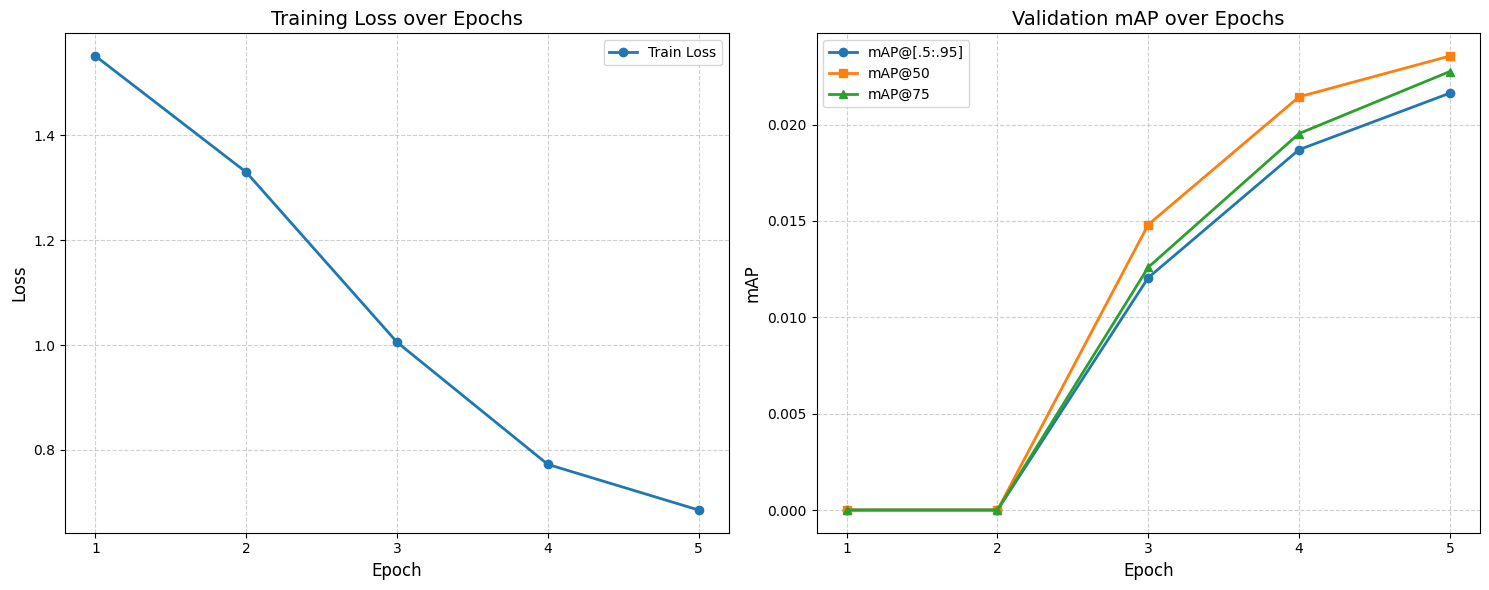

In [ ]:
plot_detection_train_log(train_losses, *zip(*[(score["map"], score["map_50"], score["map_75"]) for score in scores]))

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch: 6 | Train Loss: 0.6618 | Val mAP: 0.0243 | Val mAP@50: 0.0261 | Val mAP@75: 0.0256


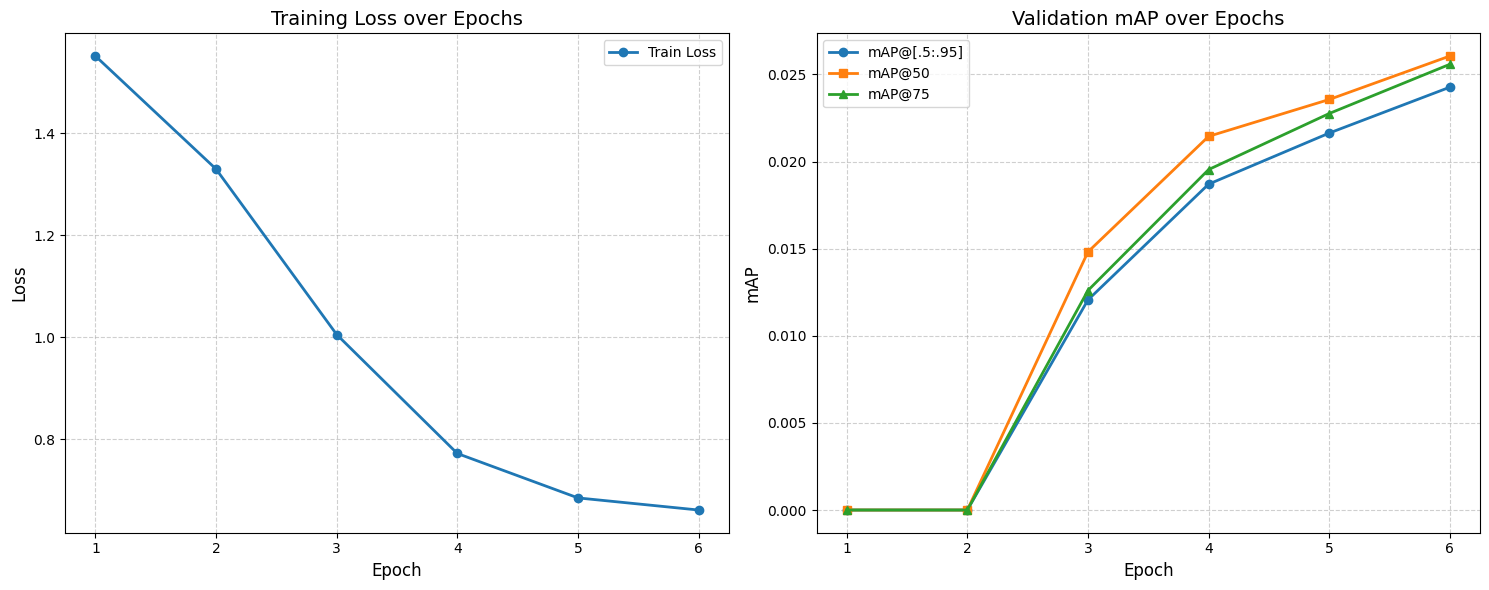

Epoch: 7 | Train Loss: 0.6105 | Val mAP: 0.0277 | Val mAP@50: 0.0297 | Val mAP@75: 0.0292


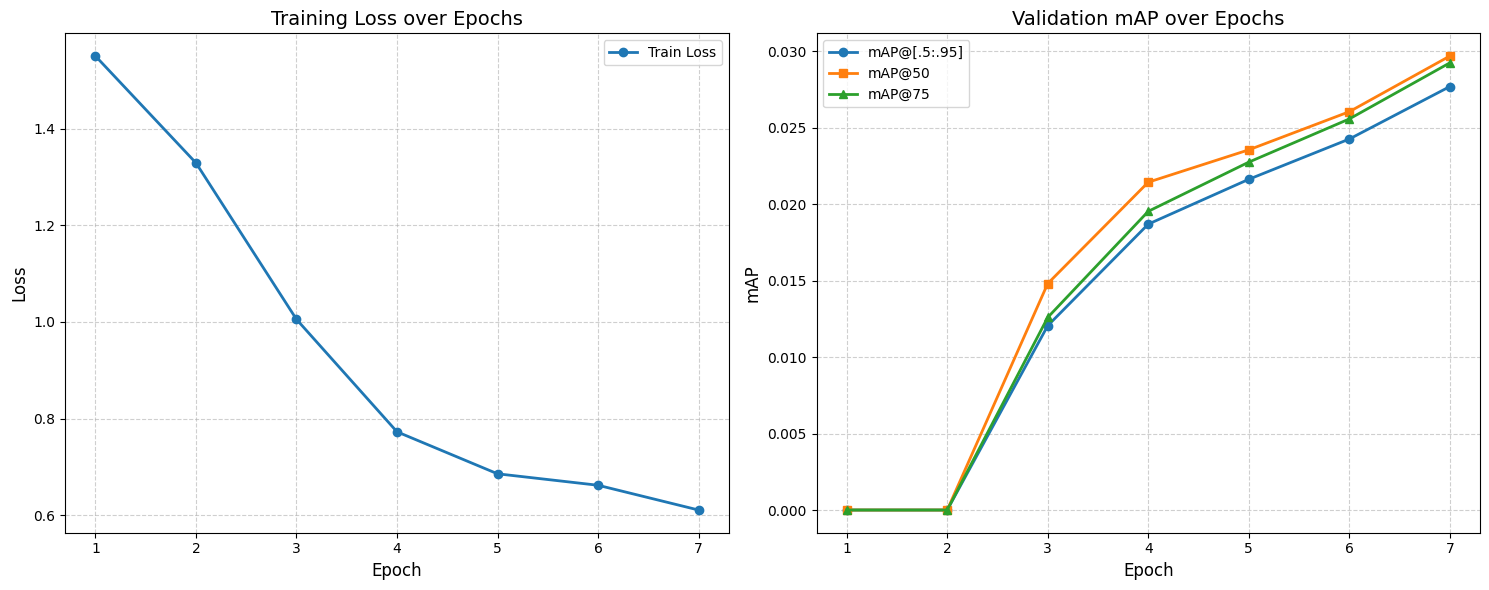

Epoch: 8 | Train Loss: 0.5775 | Val mAP: 0.0440 | Val mAP@50: 0.0463 | Val mAP@75: 0.0458


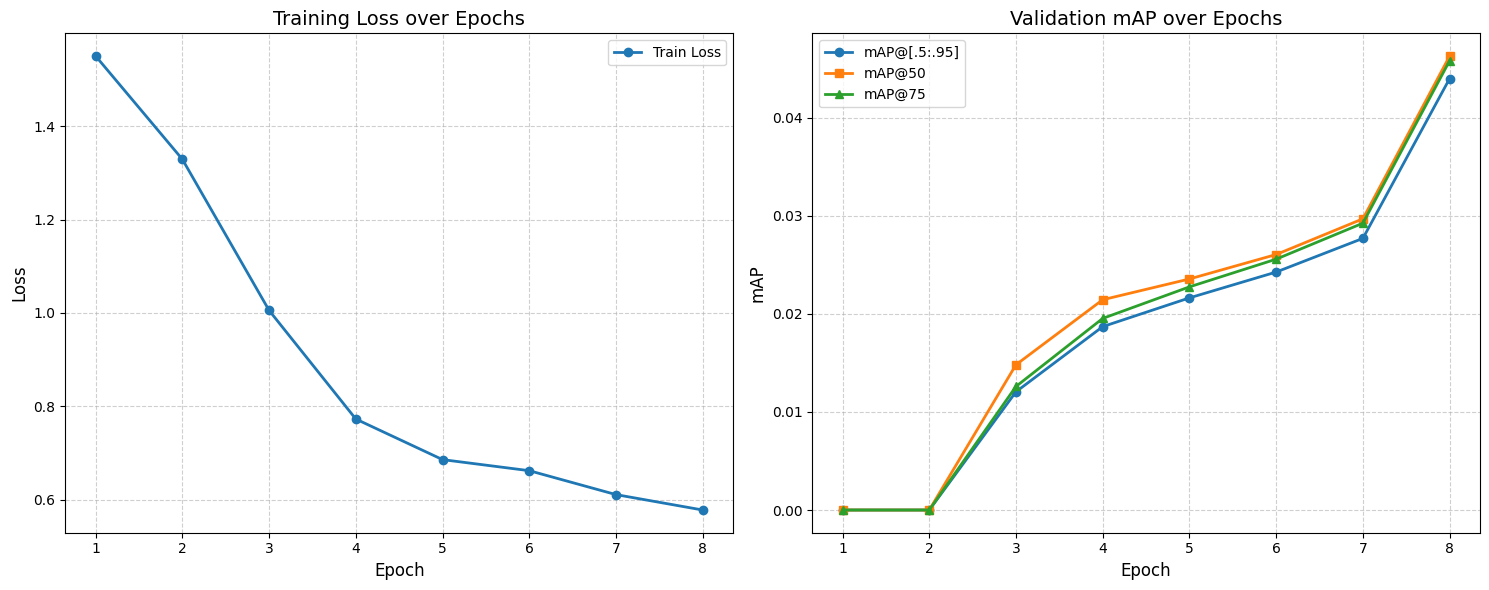

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee70517b740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ee70517b740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch: 9 | Train Loss: 0.5481 | Val mAP: 0.0601 | Val mAP@50: 0.0635 | Val mAP@75: 0.0625


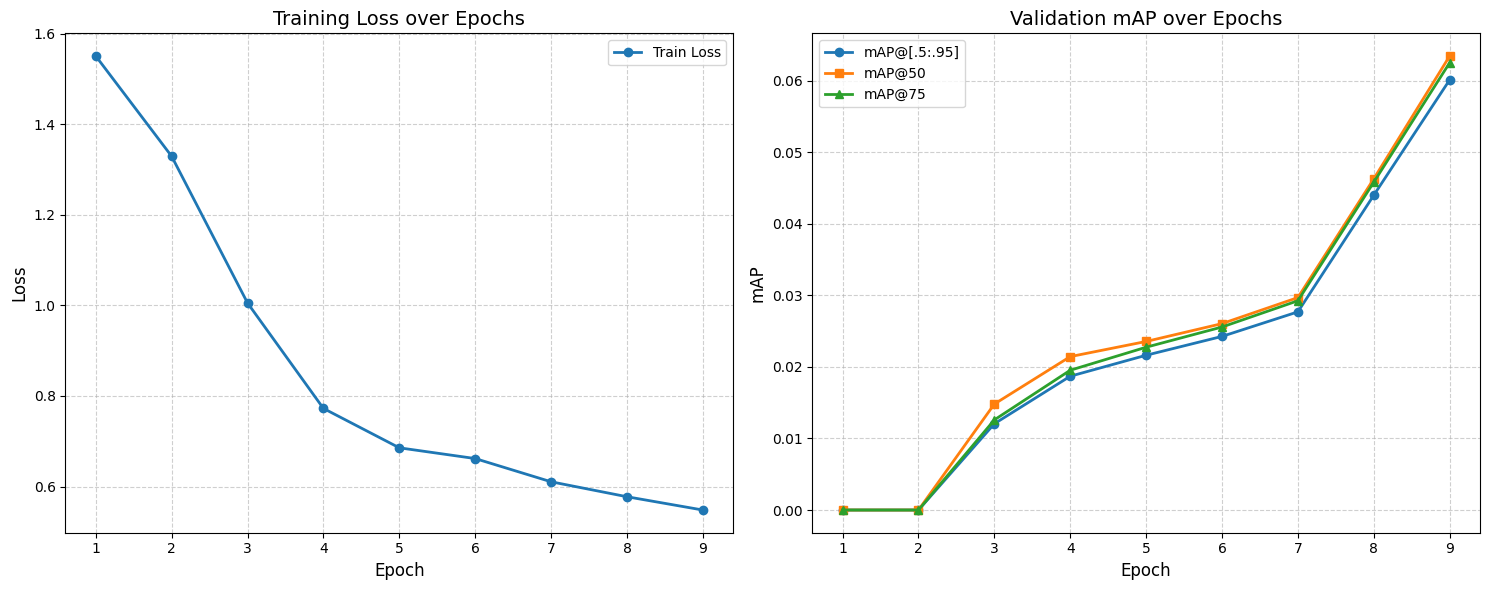

Epoch: 10 | Train Loss: 0.5259 | Val mAP: 0.0621 | Val mAP@50: 0.0668 | Val mAP@75: 0.0664


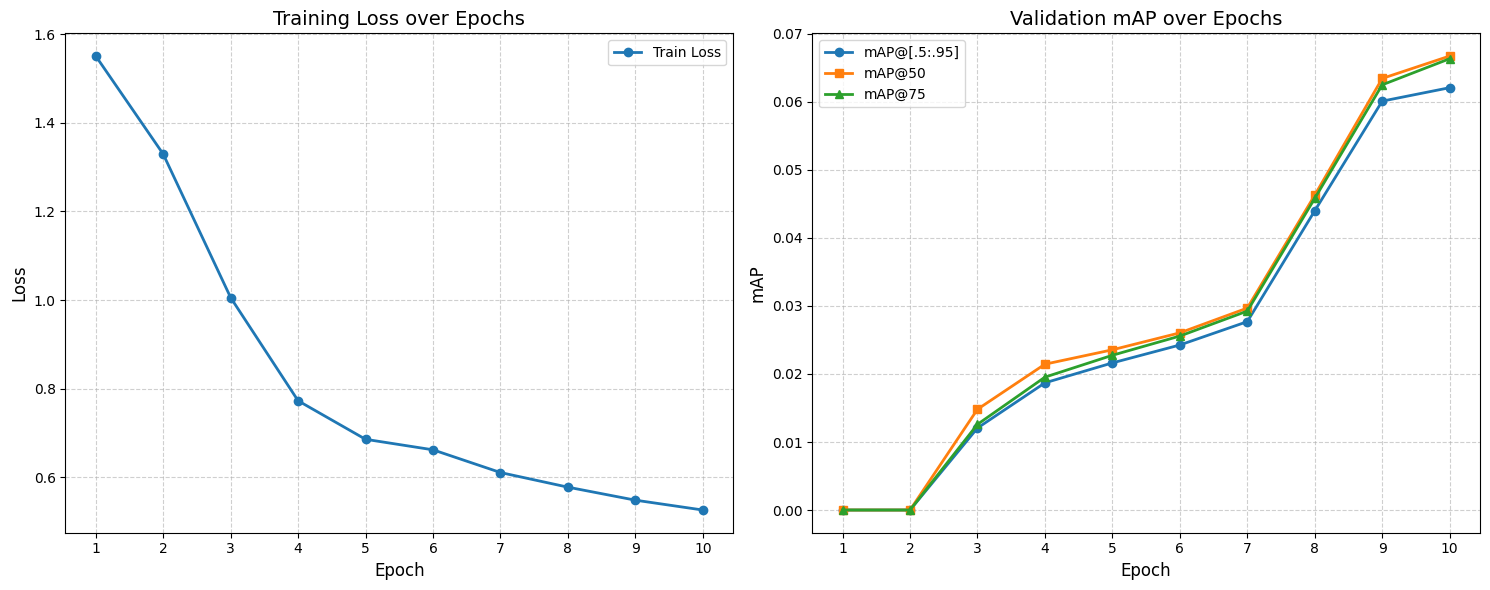

In [ ]:
start_epoch = 5

for epoch in range(start_epoch + 1, start_epoch + n_epochs + 1):
  loss = train_epoch(train_dataloader, model, optimizer)
  score = validate_epoch(test_dataloader, model)

  train_losses.append(loss)
  scores.append(score)

  print(f"Epoch: {epoch} | "
        f"Train Loss: {loss:.4f} | "
        f"Val mAP: {score['map'].item():.4f} | "
        f"Val mAP@50: {score['map_50'].item():.4f} | "
        f"Val mAP@75: {score['map_75'].item():.4f}")

  plot_detection_train_log(train_losses, *zip(*[(score["map"], score["map_50"], score["map_75"]) for score in scores]))

In [ ]:
torch.save(
  {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": 10,
    "logs": {
      "losses": train_losses,
      "scores": scores
    }
  },
  "/content/drive/MyDrive/model/retinanet_renset50_fpn_diatom_250430_2.pth"
)

In [ ]:
check = torch.load("/content/drive/MyDrive/model/retinanet_renset50_fpn_diatom_250430_2.pth", map_location=device)

model = get_retinanet_model(len(classes))
model.to(device)

optimizer = torch.optim.SGD(
  [p for p in model.parameters() if p.requires_grad],
  lr=0.001,
  momentum=0.9)

model.load_state_dict(check["model_state_dict"])
optimizer.load_state_dict(check["optimizer_state_dict"])

In [ ]:
losses, scores = check["logs"].values()